<a href="https://colab.research.google.com/github/brunotagoncalves/MeLi_2021_demand_prediction/blob/main/meli_EDA_5th_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data 

In [5]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 5.6 kB/s 


In [ ]:
!wget https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv -P drive/MyDrive/MeLi-2021/row/
!wget https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet -P drive/MyDrive/MeLi-2021/row/
!wget https://meli-data-challenge.s3.amazonaws.com/2021/items_static_metadata_full.jl -P drive/MyDrive/MeLi-2021/row/
!wget https://meli-data-challenge.s3.amazonaws.com/2021/sample_submission.csv.gz -P drive/MyDrive/MeLi-2021/row/

In [6]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz 
!wget -P spark_tgz/ http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz

--2021-07-25 02:38:39--  http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving www-eu.apache.org (www-eu.apache.org)... 95.216.26.30, 2a01:4f9:2a:1a61::2
Connecting to www-eu.apache.org (www-eu.apache.org)|95.216.26.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz [following]
--2021-07-25 02:38:39--  https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.209.10, 88.99.95.219, 135.181.214.104, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.209.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz’

spark-2.4.8-bin-had 100%[===================>] 224.97M  18.3MB/s    in 13s     

2021-07-25 02:38:53 (16.8 MB/s) - ‘spark_tgz/spark

In [7]:
!tar -xf spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz -C spark_tgz/
!pip install -q findspark
!pip install -q pyspark

     |████████████████████████████████| 212.4 MB 56 kB/s 
     |████████████████████████████████| 198 kB 49.2 MB/s 


In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark_tgz/spark-2.4.8-bin-hadoop2.7"

In [9]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [102]:
import pyspark.sql.functions  as F

In [10]:
import pandas as pd 
import numpy as np


In [7]:
df_spark = spark.read.format('parquet').load("drive/MyDrive/MeLi-2021/row/train_data.parquet")

In [8]:
df_spark.count()

37660279

In [9]:
df_spark.createOrReplaceTempView('df')

In [10]:
spark.sql("""
SELECT df.*
  ,minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) diff_minutes_active
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) < 0 THEN 'Ruptura'END) Ruptura
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) > 0 THEN 'Estoque'END) Estoque
  
FROM df
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')

In [11]:
spark.sql("""
SELECT df_re.*
  ,CASE WHEN Ruptura is null and Estoque is null and minutes_active>0 and diff_minutes_active is null then 'Estoque'
        --WHEN Estoque is not null then 'Estoque'
        WHEN minutes_active = diff_minutes_active	and Estoque is not null then 'Estoque'
        --WHEN Ruptura is not null and Estoque is null then 'Ruptura'
        WHEN Ruptura is not null and Estoque is null and minutes_active=0  then 'Ruptura'
        END STATUS_RUPTURA
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [12]:
spark.sql("""
SELECT df_re.*
  ,COUNT(CASE WHEN STATUS_RUPTURA IS NOT NULL THEN 1 END) over (partition by sku order by date ) ciclo_ruptura
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [13]:
spark.sql("""
SELECT df_re.*
  ,SUM(sold_quantity) over (partition by sku,ciclo_ruptura order by date desc) sum_sold_quantity 
  ,sum(case when sold_quantity >0 then current_price*sold_quantity end) over (partition by sku,ciclo_ruptura order by date desc)/SUM(sold_quantity) over (partition by sku,ciclo_ruptura order by date desc) avg_current_price 
  ,SUM(minutes_active) over (partition by sku,ciclo_ruptura order by date desc)/60/24 days_active_nround
  ,round(SUM(minutes_active) over (partition by sku,ciclo_ruptura order by date desc) /60/24 + 0.5,0) days_active 
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [14]:
spark.sql("""
SELECT df_re.*  
  ,min(days_active_nround) over (partition by sku,ciclo_ruptura order by date desc)>0 FLG_ruptura 
FROM df_re
--where sku = 0
--order by sku, date
""").filter('FLG_ruptura=True').drop(*['sold_quantity','minutes_active','diff_minutes_active',	'Ruptura',	'Estoque',	'STATUS_RUPTURA',	'ciclo_ruptura']).createOrReplaceTempView('df_final')#.toPandas()

In [15]:
%%time
spark.sql("""
SELECT *
FROM df_final
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/refine/df_final/')

CPU times: user 1.32 s, sys: 152 ms, total: 1.47 s
Wall time: 3min 54s


In [16]:
df = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/refine/df_final/')

In [17]:
df.count()

28096162

In [18]:
spark.sql("""
SELECT sku
  , sum(sold_quantity) total_sold_quantity 
  , max(sold_quantity) max_sold_quantity 
  , min(case when sold_quantity>0 then sold_quantity end) min_sold_quantity 
  , avg(case when sold_quantity>0 then sold_quantity end) avg_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.5) median_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.25) qt1_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.75) qt3_sold_quantity 

  , sum(current_price*sold_quantity) total_fat 
  , max(current_price*sold_quantity) max_fat  
  , min(case when sold_quantity>0 then current_price*sold_quantity end) min_fat 
  , avg(case when sold_quantity>0 then current_price*sold_quantity end) avg_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5) median_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25) qt1_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75) qt3_fat

  , sum(case when sold_quantity>0 then current_price*sold_quantity end)/sum(sold_quantity) avg_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5)/sum(sold_quantity) median_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25)/sum(sold_quantity) qt1_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75)/sum(sold_quantity) qt3_price
FROM df
GROUP BY sku
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/refine/agreg/')

In [19]:
g_df = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/refine/agreg/')
g_df.createOrReplaceTempView('g_df')

In [20]:
spark.read.format('json').load('drive/MyDrive/MeLi-2021/row/items_static_metadata_full.jl').createOrReplaceTempView('items')

In [21]:
spark.sql("""
SELECT df_final.sku ,
  date ,
  current_price ,
  currency ,
  listing_type ,
  shipping_logistic_type ,
  shipping_payment ,
  sum_sold_quantity ,
  avg_current_price ,
  days_active_nround ,
  days_active ,
  FLG_ruptura ,

  total_sold_quantity ,
  max_sold_quantity ,
  min_sold_quantity ,
  avg_sold_quantity ,
  median_sold_quantity ,
  qt1_sold_quantity ,
  qt3_sold_quantity ,
  total_fat ,
  max_fat ,
  min_fat ,
  avg_fat ,
  median_fat ,
  qt1_fat ,
  qt3_fat ,
  avg_price ,
  median_price ,
  qt1_price ,
  qt3_price ,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 

FROM df_final
LEFT JOIN g_df 
  ON g_df.sku = df_final.sku
LEFT JOIN items 
  ON items.sku = df_final.sku
""").createOrReplaceTempView('df_final_join')

In [22]:
spark.read.option("header",True).format('csv').load('drive/MyDrive/MeLi-2021/row/test_data.csv').createOrReplaceTempView('test_data')


In [23]:
spark.sql("""
SELECT test_data.sku ,
  target_stock ,
  total_sold_quantity ,
  max_sold_quantity ,
  min_sold_quantity ,
  avg_sold_quantity ,
  median_sold_quantity ,
  qt1_sold_quantity ,
  qt3_sold_quantity ,
  total_fat ,
  max_fat ,
  min_fat ,
  avg_fat ,
  median_fat ,
  qt1_fat ,
  qt3_fat ,
  avg_price ,
  median_price ,
  qt1_price ,
  qt3_price ,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 
FROM test_data
LEFT JOIN g_df 
  ON g_df.sku = test_data.sku
LEFT JOIN items 
  ON items.sku = test_data.sku
""").createOrReplaceTempView('test_data_join')

In [24]:
%%time
spark.sql("""
SELECT *
FROM df_final_join
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/df_final_join/')

CPU times: user 2.48 s, sys: 287 ms, total: 2.77 s
Wall time: 7min 13s


In [25]:
%%time
spark.sql("""
SELECT *
FROM test_data_join
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/test_data_join/')

CPU times: user 117 ms, sys: 10 ms, total: 127 ms
Wall time: 21.3 s


In [157]:
df_final = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/df_final_join/')
submit_data = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/test_data_join/')

In [158]:
submit_data = submit_data.withColumn('sum_sold_quantity',submit_data.target_stock)
#df_final = df_final.withColumn('target_stock',df_final.sum_sold_quantity)

In [159]:
df_final = df_final.filter("sum_sold_quantity>0") # estou na dúvida se deveriamos considerar como days como 30 nesse caso 
df_final = df_final.join(submit_data.select('sku','target_stock'),on='sku',how='inner')

In [160]:
df_final = df_final.filter(F.expr("(sum_sold_quantity/target_stock-1)<=0.5"))
#df_final = df_final.withColumn('target_stock',df_final.sum_sold_quantity)

In [161]:
df_final.count()

10840251

In [162]:
df_final.select(F.col('sum_sold_quantity').cast('float')).describe().toPandas()

,summary,sum_sold_quantity
0,count,10840251
1,mean,15.315803665431732
2,stddev,110.03755871602117
3,min,1.0
4,max,44456.0


In [163]:
submit_data.select(F.col('target_stock').cast('float')).describe().toPandas()

,summary,target_stock
0,count,551472
1,mean,18.06947224881771
2,stddev,122.71115112132418
3,min,1.0
4,max,32710.0


In [164]:
df_train, df_test = df_final.sample(fraction=300000/df_final.count(),seed=123).randomSplit([2.,1.],seed=123)

In [165]:
from catboost import Pool, CatBoostClassifier

In [166]:
vars = ['sku',
 'sum_sold_quantity','avg_price','total_sold_quantity','max_sold_quantity'
 ]
cat_vars =  ['sku'
 ]

In [167]:
train_data = df_train.select(*vars+['days_active']).toPandas()
test_data = df_test.select(*vars+['days_active']).toPandas()
train_label = train_data.days_active
test_label = test_data.days_active

In [168]:
# initialize data
#train_data = g_df.loc[:,vars].sample(frac=.01,random_state=123)
#train_label = g_df.loc[:,'days_active'].apply(lambda x : x if x<30. else 30.).round().astype(int).sample(frac=.01,random_state=123)
#test_data = g_df.loc[~g_df.sku.isnull(),'current_price_count':'shipping_payment_shipping_payment']#.sample(frac=.1,random_state=1234)
# initialize Pool
train_pool = Pool(train_data.loc[:,vars], 
                  train_label, 
                  cat_features=cat_vars)
test_pool = Pool(test_data.loc[:,vars], 
                  test_label, 
                  cat_features=cat_vars)

# specify the training parameters 
model = CatBoostClassifier(task_type='GPU',metric_period=100,learning_rate=0.05)
#train the model
model.fit(train_pool,eval_set=test_pool)
# make the prediction using the resulting model

0:	learn: 4.0345364	test: 4.0484276	best: 4.0484276 (0)	total: 303ms	remaining: 5m 2s
100:	learn: 3.3558862	test: 3.3722550	best: 3.3722550 (100)	total: 24.6s	remaining: 3m 39s
200:	learn: 3.3119103	test: 3.3436723	best: 3.3436723 (200)	total: 48.9s	remaining: 3m 14s
300:	learn: 3.2874637	test: 3.3335771	best: 3.3335771 (300)	total: 1m 13s	remaining: 2m 50s
400:	learn: 3.2704426	test: 3.3297027	best: 3.3297027 (400)	total: 1m 38s	remaining: 2m 26s
500:	learn: 3.2548943	test: 3.3270325	best: 3.3270325 (500)	total: 2m 3s	remaining: 2m 2s
600:	learn: 3.2406503	test: 3.3254220	best: 3.3254220 (600)	total: 2m 28s	remaining: 1m 38s
700:	learn: 3.2289827	test: 3.3248861	best: 3.3248861 (700)	total: 2m 53s	remaining: 1m 14s
800:	learn: 3.2161283	test: 3.3249462	best: 3.3248861 (700)	total: 3m 19s	remaining: 49.5s
900:	learn: 3.2045633	test: 3.3254357	best: 3.3248861 (700)	total: 3m 44s	remaining: 24.6s
999:	learn: 3.1932786	test: 3.3257245	best: 3.3248861 (700)	total: 4m 9s	remaining: 0us
best

In [169]:
pd.Series(model.feature_importances_,model.feature_names_).sort_values()

avg_price               6.340867
sku                     9.176952
max_sold_quantity      12.440219
total_sold_quantity    29.144596
sum_sold_quantity      42.897366
dtype: float64

In [170]:
model.score(test_pool),model.score(train_pool)

(0.08060377661067233, 0.10321321321321321)

In [133]:
model.score(test_pool),model.score(train_pool)

(0.058695020393438026, 0.09590788999639727)

In [67]:
model.score(test_pool),model.score(train_pool)

(0.06427292879242286, 0.09400369222030248)

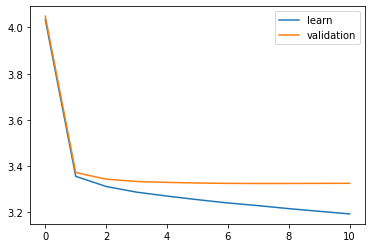

In [171]:
list_pd = [pd.DataFrame.from_dict(model.evals_result_[i]) for i in model.evals_result_]

list_pd = pd.concat(list_pd,axis=1)
list_pd.columns=[i for i in model.evals_result_]
list_pd.plot()


In [172]:

submit_pool = Pool(submit_data.select(*vars).toPandas(),
                 cat_features=cat_vars) 


In [173]:
preds= model.predict(submit_pool)
pd.DataFrame(preds).describe()#.hist()

,0
count,551472.000000
mean,15.800191
std,18.282859
min,1.000000
25%,3.000000
50%,8.000000
75%,20.000000
max,60.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bc51e6ad0>]],
      dtype=object)

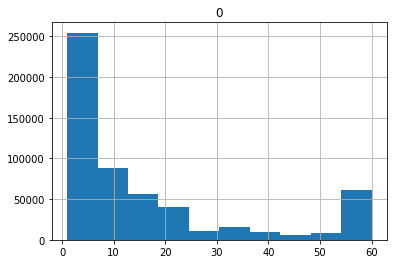

In [175]:
pd.DataFrame(preds).hist()

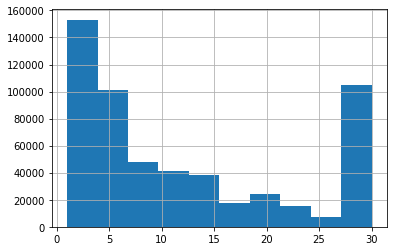

In [176]:
pd.DataFrame(preds).apply(lambda x : x[0] if x[0]<30 else 30,axis=1).hist()

In [177]:
result = pd.DataFrame(model.predict_proba(submit_pool))#.round(4)#.to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)

In [178]:
result.loc[:,29] = result.loc[:,29:].sum(axis=1)#.apply(lambda x : x if x<1. else 1. )

In [92]:
(result.loc[:,:29].round(4)>1).any(axis=1).sum()

0

In [179]:
result.loc[:,:29].round(4).to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)